# Homework #7: Boosting and Support Vector Machines

You're working for a car manufacturer that is looking to implement driver assistance features such as automated steering and adaptive cruise control. While technologically advanced, these systems still require driver attention. Some manufacturers simply require keeping your hands on the wheel but your company would also like to ensure the driver's focus remains on the road. To accomplish this, they'd like you to construct a model that can use the position of facial features to determine whether the driver is looking straight or not.

A separate system has been used to extract the eye, mouth, and nose positions from images taken of the driver, your goal is to use these features to predict the direction of the driver's gaze. The dataset listed below has been provided for these tasks.

### Relevant Dataset
`drivPoints.txt`

* Response Variable: `label`. Note: this includes looking left, right, and straight. We will convert this to a binary response.
* Predictor Variables:
    * [`xF` `yF` `wF` `hF`] = face position
    * [`xRE` `yRE`] = right eye position
    * [`xLE` `yL`] = left eye position
    * [`xN` `yN`] = Nose position
    * [`xRM` `yRM`] = right corner of mouth
    * [`xLM` `yLM`] = left corner of mouth
    
### Source
https://archive.ics.uci.edu/ml/datasets/DrivFace

## Task 1: Import the dataset and create a binary variable of `lookingStraight`. Split into train/test set.
This variable should take the value of `1` when `label=2` and `0` everywhere else. There should be a large class imbalance between looking straight or not (which you would expect given the people are driving).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import time
from collections import Counter, defaultdict
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

%matplotlib inline

In [ ]:
df = pd.read_csv("/content/drivPoints.txt", sep=",")
df.head()

,fileName,subject,imgNum,label,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM
0,20130529_01_Driv_001_f,1,1,2,0,292,209,100,112,323,232,367,231,353,254,332,278,361,278
1,20130529_01_Driv_002_f,1,2,2,0,286,200,109,128,324,235,366,235,353,258,333,281,361,281
2,20130529_01_Driv_003_f,1,3,2,0,290,204,105,121,325,240,367,239,351,260,334,282,362,282
3,20130529_01_Driv_004_f,1,4,2,0,287,202,112,118,325,230,369,230,353,253,335,274,362,275
4,20130529_01_Driv_005_f,1,5,2,0,290,193,104,119,325,224,366,225,353,244,333,268,363,268


In [ ]:
df['lookingStraight']=np.where(df['label']!= 2, 0, 1)
df=df.drop(['fileName'], axis=1)
df.head()

,subject,imgNum,label,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM,lookingStraight
0,1,1,2,0,292,209,100,112,323,232,367,231,353,254,332,278,361,278,1
1,1,2,2,0,286,200,109,128,324,235,366,235,353,258,333,281,361,281,1
2,1,3,2,0,290,204,105,121,325,240,367,239,351,260,334,282,362,282,1
3,1,4,2,0,287,202,112,118,325,230,369,230,353,253,335,274,362,275,1
4,1,5,2,0,290,193,104,119,325,224,366,225,353,244,333,268,363,268,1


In [ ]:
splits = np.random.choice(a = 3, size = df.shape[0], p = [0.7,0.15,0.15])
df = pd.get_dummies(data=df, drop_first=True)

In [ ]:
df

,subject,imgNum,label,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM,lookingStraight
0,1,1,2,0,292,209,100,112,323,232,367,231,353,254,332,278,361,278,1
1,1,2,2,0,286,200,109,128,324,235,366,235,353,258,333,281,361,281,1
2,1,3,2,0,290,204,105,121,325,240,367,239,351,260,334,282,362,282,1
3,1,4,2,0,287,202,112,118,325,230,369,230,353,253,335,274,362,275,1
4,1,5,2,0,290,193,104,119,325,224,366,225,353,244,333,268,363,268,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,4,86,2,-15,278,183,128,141,307,218,354,210,330,247,324,273,356,266,1
602,4,87,1,-30,268,186,128,134,296,222,344,212,319,247,316,274,347,269,0
603,4,88,1,-30,264,187,127,131,287,220,334,211,304,247,305,272,337,270,0
604,4,89,2,-15,264,175,143,136,295,207,345,200,320,234,314,261,351,251,1


In [ ]:
df = df.drop(['label'], axis=1)

In [ ]:
df.head()

,subject,imgNum,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM,lookingStraight
0,1,1,0,292,209,100,112,323,232,367,231,353,254,332,278,361,278,1
1,1,2,0,286,200,109,128,324,235,366,235,353,258,333,281,361,281,1
2,1,3,0,290,204,105,121,325,240,367,239,351,260,334,282,362,282,1
3,1,4,0,287,202,112,118,325,230,369,230,353,253,335,274,362,275,1
4,1,5,0,290,193,104,119,325,224,366,225,353,244,333,268,363,268,1


In [ ]:
Counter(df.lookingStraight)

Counter({1: 546, 0: 60})

In [ ]:
df_train = df.iloc[np.where(splits == 0)[0],:]
df_val = df.iloc[np.where(splits == 1)[0],:]
df_test = df.iloc[np.where(splits == 2)[0],:]

In [ ]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(418, 18)
(84, 18)
(104, 18)


In [ ]:
xtrain = df_train.iloc[:,:-1]
ytrain = df_train.iloc[:,-1]
xtest = df_test.iloc[:,:-1]
ytest = df_test.iloc[:,-1]

In [ ]:
xval = df_val.iloc[:,:-1]
yval = df_val.iloc[:,-1]

## Task 2: Perform a cross-validated (or use a single validation set) grid search of the hyperparameters for the `GradientBoostingClassifier` to find the best model.
You should at least tune the learning rate and number of trees in the model but feel free to go as deep as you'd like on this analysis).

In [ ]:
xval

,subject,imgNum,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM
16,1,17,0,282,209,108,109,318,232,362,231,346,252,328,277,358,277
33,1,34,0,275,221,122,128,311,249,363,250,334,277,317,297,353,298
37,1,38,0,284,220,120,130,325,247,376,250,352,274,331,297,365,295
42,1,43,0,287,218,122,127,331,245,379,246,359,274,334,294,372,294
52,1,53,0,284,204,127,128,333,234,378,237,361,262,336,281,373,281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,4,46,-15,271,189,120,132,300,222,347,213,323,243,318,275,350,266
568,4,53,15,342,178,104,138,376,203,420,205,412,232,383,260,414,264
570,4,55,15,344,176,102,137,382,202,428,204,411,234,385,258,420,261
587,4,72,15,324,178,107,131,358,200,407,201,389,225,364,258,405,253


Completed 1 trees
Completed 2 trees
Completed 3 trees


Text(0, 0.5, 'Validation Set Accuracy')

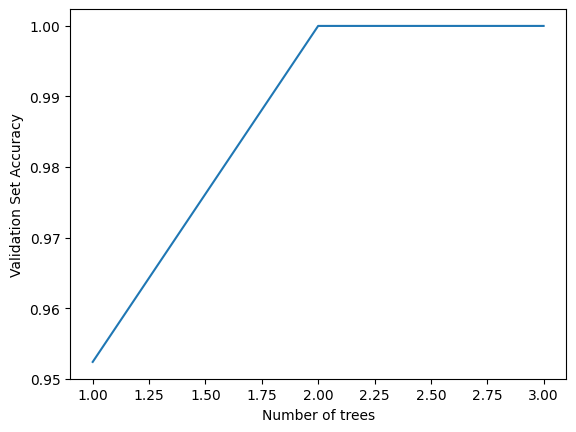

In [ ]:
num_trees = np.arange(1, 4, 1)
val_acc_list = []

for n in num_trees:
    ada = AdaBoostClassifier(n_estimators=n).fit(xtrain,ytrain)
    val_acc_list.append(ada.score(xval,yval))
    print(f'Completed {n} trees')

plt.plot(num_trees, val_acc_list)
plt.xlabel('Number of trees')
plt.ylabel('Validation Set Accuracy')

Completed learning rate of 1e-05
Completed learning rate of 0.187509375
Completed learning rate of 0.37500875
Completed learning rate of 0.5625081249999999
Completed learning rate of 0.7500074999999999
Completed learning rate of 0.937506875
Completed learning rate of 1.12500625
Completed learning rate of 1.312505625
Completed learning rate of 1.500005
Completed learning rate of 1.687504375
Completed learning rate of 1.87500375
Completed learning rate of 2.062503125
Completed learning rate of 2.2500025
Completed learning rate of 2.437501875
Completed learning rate of 2.62500125
Completed learning rate of 2.812500625
Completed learning rate of 3.0


Text(0, 0.5, 'Validation Set Accuracy')

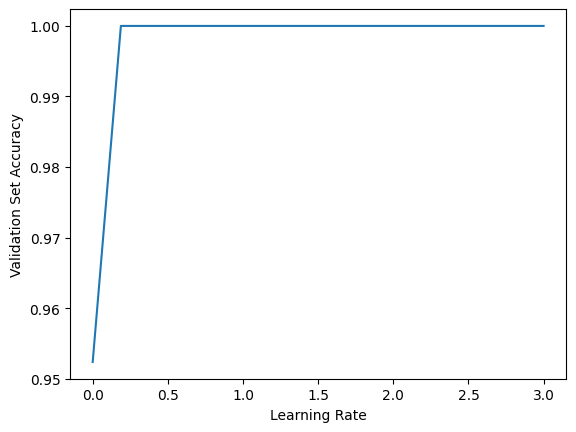

In [ ]:
learning_rates = np.linspace(0.00001,3,17)
val_acc_list = []

for lr in learning_rates:
    ada = AdaBoostClassifier(n_estimators=17, learning_rate=lr).fit(xtrain,ytrain)
    val_acc_list.append(ada.score(xval,yval))
    print(f'Completed learning rate of {lr}')

plt.plot(learning_rates, val_acc_list)
plt.xlabel('Learning Rate')
plt.ylabel('Validation Set Accuracy')

In [ ]:
learning_rates[np.argmax(val_acc_list)]

0.187509375

In [ ]:
num_trees = np.arange(1, 4, 1)
learning_rates = np.linspace(0.01,1.1,5)
depths = np.arange(1, 5, 1)
val_acc_list = []
hyperparameter_combo = []

for n in num_trees:
    for lr in learning_rates:
        for d in depths:
            boost = GradientBoostingClassifier(n_estimators=n, learning_rate=lr,
                                        max_depth=d, random_state=0).fit(xtrain, ytrain)
    
            val_acc_list.append(boost.score(xval, yval))
            print(f'Completed tree {n} and learning rate of {lr} and depth of {d}')
            hyperparameter_combo.append((n,lr,d))

Completed tree 1 and learning rate of 0.01 and depth of 1
Completed tree 1 and learning rate of 0.01 and depth of 2
Completed tree 1 and learning rate of 0.01 and depth of 3
Completed tree 1 and learning rate of 0.01 and depth of 4
Completed tree 1 and learning rate of 0.28250000000000003 and depth of 1
Completed tree 1 and learning rate of 0.28250000000000003 and depth of 2
Completed tree 1 and learning rate of 0.28250000000000003 and depth of 3
Completed tree 1 and learning rate of 0.28250000000000003 and depth of 4
Completed tree 1 and learning rate of 0.555 and depth of 1
Completed tree 1 and learning rate of 0.555 and depth of 2
Completed tree 1 and learning rate of 0.555 and depth of 3
Completed tree 1 and learning rate of 0.555 and depth of 4
Completed tree 1 and learning rate of 0.8275000000000001 and depth of 1
Completed tree 1 and learning rate of 0.8275000000000001 and depth of 2
Completed tree 1 and learning rate of 0.8275000000000001 and depth of 3
Completed tree 1 and lea

Text(0.5, 0.5, 'Max Depth')

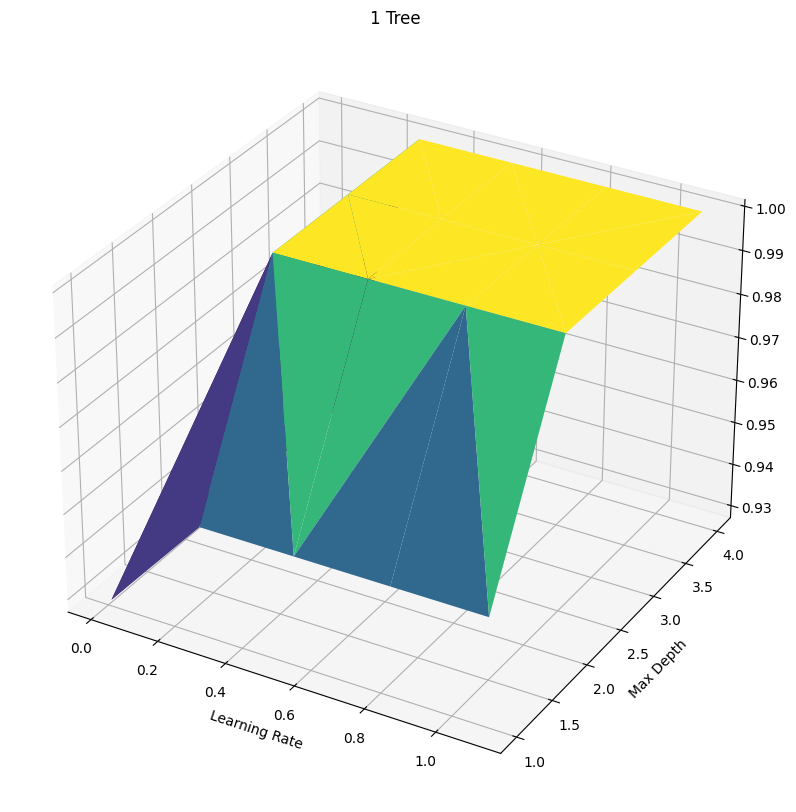

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][:20],
             list(zip(*hyperparameter_combo))[2][:20],
             val_acc_list[:20], cmap='viridis')
ax.set_title('1 Tree')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

In [ ]:
print(np.max(val_acc_list), hyperparameter_combo[np.argmax(val_acc_list)])

1.0 (1, 0.28250000000000003, 2)


Text(0.5, 0.5, 'Max Depth')

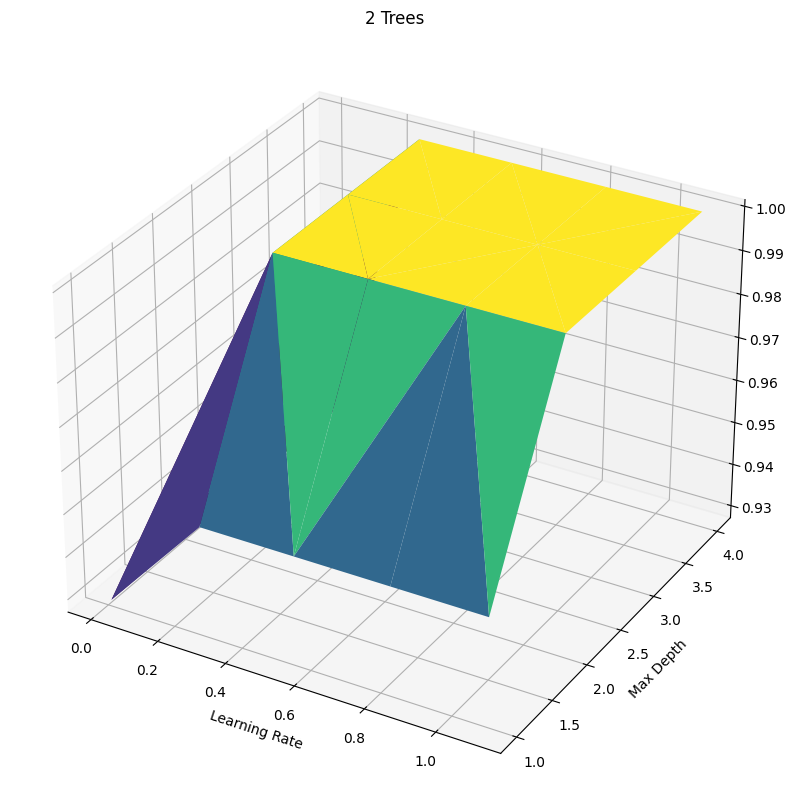

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][20:40],
             list(zip(*hyperparameter_combo))[2][20:40],
             val_acc_list[:20], cmap='viridis')
ax.set_title('2 Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

Text(0.5, 0.5, 'Max Depth')

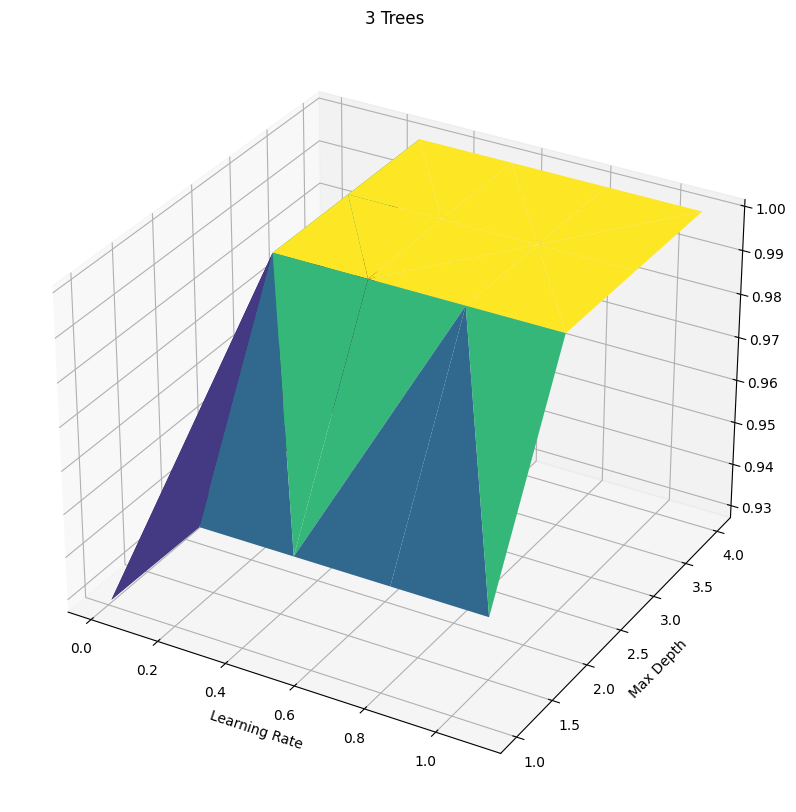

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][40:60],
             list(zip(*hyperparameter_combo))[2][40:60],
             val_acc_list[:20], cmap='viridis')
ax.set_title('3 Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

## Task 3: Perform a cross-validated (or use a single validation set) grid search of the hyperparameters for the `SVC` (Support Vector Classifier) to find the best model.
You should at least tune `C` and the `kernel` but feel free to go as deep as you'd like on this analysis).

In [ ]:
svc = SVC(C=0.01, kernel='linear')
cross_val_score(svc, xtrain, ytrain, cv=5)

array([0.89285714, 0.89285714, 0.82142857, 0.90361446, 0.81927711])

In [ ]:
params_grid = [{'kernel': ['rbf'],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [ ]:
svm_model = GridSearchCV(SVC(), params_grid, cv=5, n_jobs=6, verbose=4)
svm_model.fit(xtrain, ytrain)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=6,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             verbose=4)

In [ ]:
svm_model.cv_results_

{'mean_fit_time': array([2.38820076e-02, 1.68908119e-02, 2.34958649e-02, 3.12617779e-02,
        3.67853723e+00, 1.16160617e+01, 1.19582401e+02, 8.05238374e+02]),
 'std_fit_time': array([4.99027265e-03, 4.39658091e-03, 8.88484885e-03, 9.97239275e-03,
        4.58496798e+00, 3.48566528e+00, 6.80406918e+01, 1.54167432e+02]),
 'mean_score_time': array([0.01354351, 0.01390877, 0.01468892, 0.01130295, 0.01301446,
        0.01686826, 0.01848378, 0.0099874 ]),
 'std_score_time': array([0.00572148, 0.00226541, 0.00412967, 0.00463953, 0.00774717,
        0.00538669, 0.01142816, 0.00420368]),
 'param_C': masked_array(data=[1, 10, 100, 1000, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'rbf', 'linear', 'linear',
                    'linear', 'linear'],
              mask=[False, False, False, False, False, False, False, False],
        fil

In [ ]:
print('Best score for training data:', svm_model.best_score_)

Best score for training data: 0.9090935169248423


In [ ]:
print('Best C:',svm_model.best_estimator_.C) 
print('Best Kernel:',svm_model.best_estimator_.kernel)
print('Best Gamma:',svm_model.best_estimator_.gamma)

Best C: 10
Best Kernel: rbf
Best Gamma: scale


In [ ]:
final_model = svm_model.best_estimator_
pred = final_model.predict(xval)
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
print(confusion_matrix(yval,pred))

[[ 0  6]
 [ 0 78]]


In [ ]:
print(classification_report(yval,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.93      1.00      0.96        78

    accuracy                           0.93        84
   macro avg       0.46      0.50      0.48        84
weighted avg       0.86      0.93      0.89        84



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
boost = GradientBoostingClassifier(n_estimators=list(zip(*hyperparameter_combo))[0][np.argmax(val_acc_list)],
                                   learning_rate=list(zip(*hyperparameter_combo))[1][np.argmax(val_acc_list)],
                                   max_depth=list(zip(*hyperparameter_combo))[2][np.argmax(val_acc_list)],
                                   random_state=0).fit(xtrain, ytrain)
boost.score(xtest,ytest)

1.0

## Questions
1. Is accuracy the best metric to use in these tasks or would there have been a better one? Explain.

2. Which model gave the "best" result using the metric you chose above?

3. (Bonus) Any other interesting insights from this model or data?

Precison could be a better metric to measure by because the False Positive of guessing someone was looking straight, but were not would be more harmful to the system for identifying the reliance of the driver paying attention to the road. Using the gradient boosting classifier provided the highest accuracy to our model of 100%. Our model may be over fit.  